# Emotion Detection


In [1]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D 
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Tensorflow version: 2.11.0


 **Exploring Dataset**

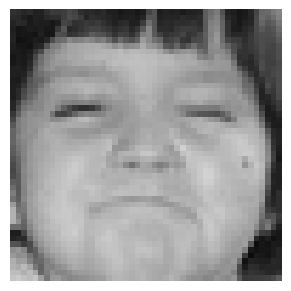

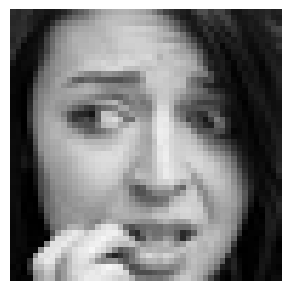

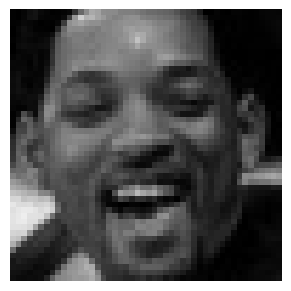

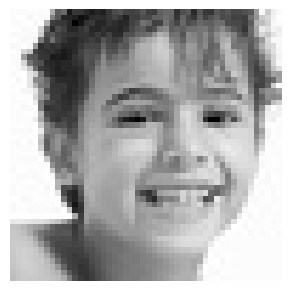

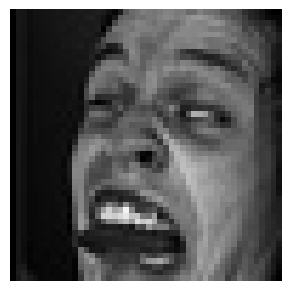

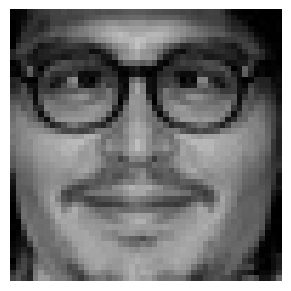

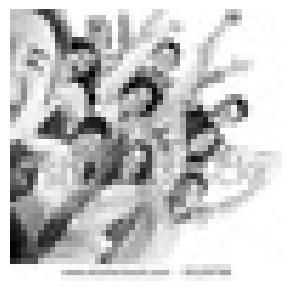

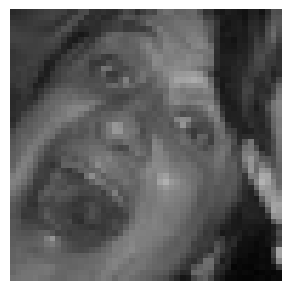

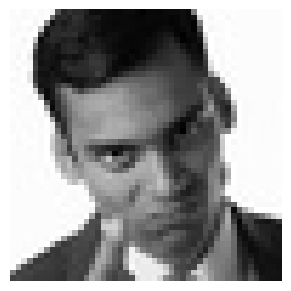

In [2]:
images = glob("/kaggle/input/fer2013/train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

**Preparing Data for Training**

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True)
train_generator = datagen_train.flow_from_directory("/kaggle/input/fer2013/train/",
                                                    target_size=(img_size, img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    shuffle=True)

datagen_validation = ImageDataGenerator()
validation_generator = datagen_train.flow_from_directory("/kaggle/input/fer2013/test/",
                                                              target_size=(img_size, img_size),
                                                              color_mode="grayscale",
                                                              batch_size=batch_size,
                                                              class_mode="categorical",
                                                              shuffle=True)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


**Defining Model**

In [4]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)
    
    return x   

In [5]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    
    return x

In [6]:
 def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs,64,(3,3))
    conv_2 = Convolution(inputs,128,(5,5))
    conv_3 = Convolution(inputs,512,(3,3))
    conv_4 = Convolution(inputs,512,(3,3))
    
    
    flatten = Flatten()(conv_3)
    
    dense_1 = Dense_f(flatten,256)
    dense_2 = Dense_f(dense_1,512)
    
    output = Dense(7,activation = "softmax")(dense_1)
    model = Model(inputs = [inputs], outputs = [output])
    
    opt = Adam(lr=0.0005)
    
    model.compile(loss = ['categorical_crossentropy'], optimizer = opt , metrics = ['accuracy'])
    
    return model

In [7]:
model = model_fer((48,48,1))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 512)       5120      
                                                                 
 batch_normalization_2 (Batc  (None, 48, 48, 512)      2048      
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 48, 48, 512)       0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 512)      0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 24, 24, 512)       0     

**Initializing the Model**

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint

model = model_fer((48,48,1))
epochs = 15
steps_per_epoch = train_generator.n //train_generator.batch_size
validation_steps = validation_generator.n //validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', save_weights_only=True, mode='max', verbose=-1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor =0.1, patience =2, min_lr=0.00001)


callbacks = [checkpoint,reduce_lr]


# Training the Model

**The next cell takes time to complete**

In [9]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)


Epoch 1/15


2023-05-23 10:14:29.756677: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


448/448 [==============================] - 124s 259ms/step - loss: 1.6908 - accuracy: 0.3565 - val_loss: 2.0361 - val_accuracy: 0.2224 - lr: 0.0010
Epoch 2/15
448/448 [==============================] - 33s 73ms/step - loss: 1.4410 - accuracy: 0.4481 - val_loss: 1.5368 - val_accuracy: 0.4167 - lr: 0.0010
Epoch 3/15
448/448 [==============================] - 38s 84ms/step - loss: 1.3263 - accuracy: 0.4988 - val_loss: 1.5650 - val_accuracy: 0.4040 - lr: 0.0010
Epoch 4/15
448/448 [==============================] - 32s 72ms/step - loss: 1.2491 - accuracy: 0.5268 - val_loss: 1.6532 - val_accuracy: 0.3719 - lr: 0.0010
Epoch 5/15
448/448 [==============================] - 32s 71ms/step - loss: 1.1260 - accuracy: 0.5870 - val_loss: 1.2787 - val_accuracy: 0.5142 - lr: 1.0000e-04
Epoch 6/15
448/448 [==============================] - 37s 83ms/step - loss: 1.0819 - accuracy: 0.6029 - val_loss: 1.2755 - val_accuracy: 0.5158 - lr: 1.0000e-04
Epoch 7/15
448/448 [==============================] - 33s 7

**Model Evaluation**

In [10]:
model.evaluate(validation_generator)

113/113 [==============================] - 6s 51ms/step - loss: 1.2522 - accuracy: 0.5325


[1.2521839141845703, 0.5324602723121643]

**Plotting Loss**

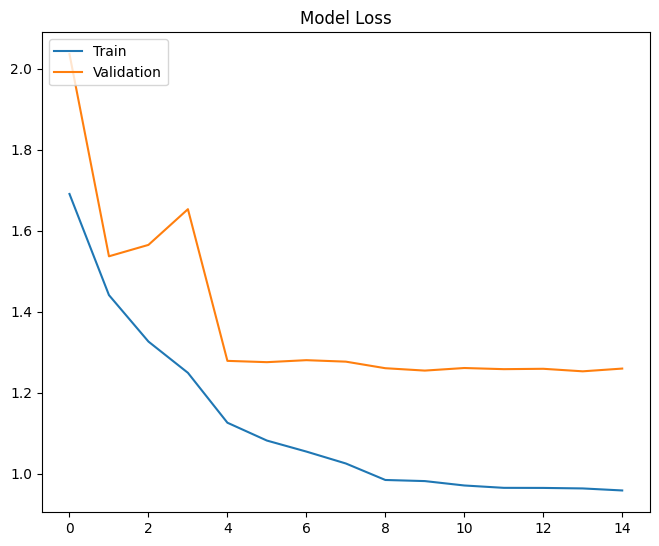

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.0, bottom=0.0, right=0.95, left=0.0, hspace=0.25, wspace=0.35)
plt.show()

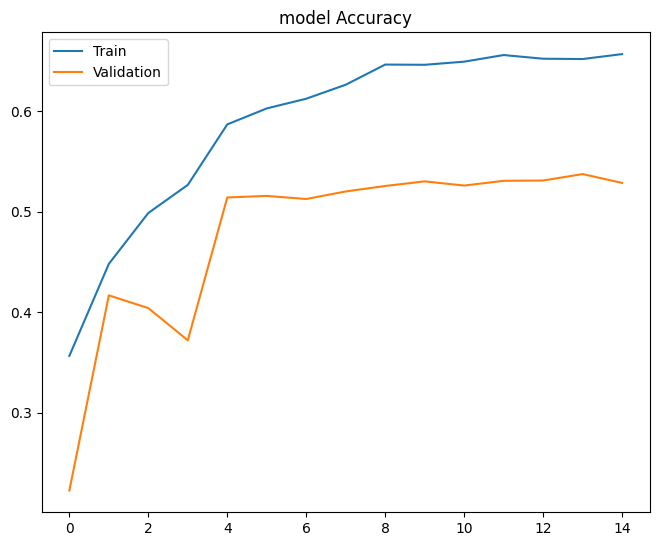

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.0, bottom=0.0, right=0.95, left=0.0, hspace=0.25, wspace=0.35)
plt.show()

**Saving Model Architecture**


In [13]:
model_json = model.to_json()
with open("model_a.json","w") as json_file:
    json_file.write(model_json)